In [1]:

import pandas as pd

from sklearn.externals import joblib
# Added version check for recent scikit-learn 0.18 checksok ca
from distutils.version import LooseVersion as Version
import numpy as np
from dateutil.parser import parse
import datetime as dt
from numba import jit

from tqdm import tqdm, tqdm_notebook

from collections import OrderedDict as od
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns
import random, os, csv      # random is the rng, os is the operating system, and csv handles
                            # CSV files
import matplotlib.pyplot as plt  # This is the plotter
import time                 # This allows for lots of neat tricks.
import powerlaw
import mpmath
# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns


import statsmodels.api as sm
import math
plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
#plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

import powerlaw
import mpmath
import pylab
pylab.rcParams['xtick.major.pad']='8'
pylab.rcParams['ytick.major.pad']='8'
#pylab.rcParams['font.sans-serif']='Arial'

from matplotlib import rc
rc('font', family='sans-serif')
rc('font', size=10.0)
rc('text', usetex=False)


from matplotlib.font_manager import FontProperties

panel_label_font = FontProperties().copy()
panel_label_font.set_weight("bold")
panel_label_font.set_size(12.0)
panel_label_font.set_family("sans-serif")

def plot_basics(data, data_inst, fig, units):
    from powerlaw import plot_pdf, Fit, pdf
    annotate_coord = (-.4, .95)
    ax1 = fig.add_subplot(n_graphs,n_data,data_inst)
    x, y = pdf(data, linear_bins=True)
    ind = y>0
    y = y[ind]
    x = x[:-1]
    x = x[ind]
    ax1.scatter(x, y, color='r', s=.5)
    plot_pdf(data[data>0], ax=ax1, color='b', linewidth=2)
    from pylab import setp
    setp( ax1.get_xticklabels(), visible=False)
from pylab import setp


In [2]:
def returns(s):
    #compute log returns
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def tick_bars(df, price_column, m):
    '''
    compute tick bars
    # args
        df: pd.DataFrame()
        column: name for price data
        m: int(), threshold value for ticks
    # returns
        idx: list of indices
    '''
    t = df[price_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += 1
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx
def tick_bar_df(df, price_column, m):
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx]
#========================================================
def volume_bars(df, volume_column, m):
    '''
    compute volume bars
    # args
        df: pd.DataFrame()
        column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx]
#========================================================
def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars
    # args
        df: pd.DataFrame()
        column: name for dollar volume data
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx]
#========================================================
dataparser = lambda x: pd.datetime.strptime(x, '%M:%S.%f').time
#========================================================
@jit(nopython=True)
def mad_outlier(y, thresh=3.):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


In [7]:
os.getcwd()
data_only_drive = '/media/ak/DataOnly/'  # external date only drive
# quotes=[s for s in os.listdir(data_only_drive) if s.endswith('quotes')]
# trades=[s for s in os.listdir(data_only_drive) if s.endswith('trades')]
YM1_trades=[s for s in os.listdir(data_only_drive) if s.startswith('YM1') and s.endswith('trades')]
YM1_quotes=[s for s in os.listdir(data_only_drive) if s.startswith('YM1') and s.endswith('quotes')]

In [9]:
YM1_quotes

['YM1_Comdty_quotes']

In [4]:

# clean_files_data = "".join((data_only_drive,'/BTCUSD.PERP.BMEX/'))
# raw_crypto_data_lob = '/media/ak/DataOnly/crypto/LOB/BTCUSD.PERP.BMEX/' #btc perp data
# clean_crypto_files = os.listdir(clean_files_data)
# csv_files = [s for s in os.listdir(raw_crypto_data_lob) if s.endswith('.csv')]
# low_memory = False

In [10]:
# # cleaning first stack of crypto-data
# mylist = []
# fields = ['happened_at', 'BIDPRC1', 'BIDSIZE1', 'ASKPRC1', 'ASKSIZE1']

# # for csv_files_idx, csv_date in enumerate(csv_files):
# #     print csv_date
# csv_files_idx=3
# csv_loc = "/".join((raw_crypto_data_lob,csv_files[csv_files_idx]))
# for chunk in pd.read_csv(csv_loc, chunksize=2000, skipinitialspace=True, usecols=fields, error_bad_lines=False, engine='python'):
#     mylist.append(chunk)
#     print chunk.head(4)
#     big_data_df = pd.concat(mylist, axis=0)
# del mylist
# print df_name
# # df_name = "".join((clean_files_data,csv_files_idx,".csv"))
# # big_data_df.to_csv(df_name)

In [11]:
# import os
# data_drive=data_only_drive
# clean_files_data = "".join((data_drive,'/BTCUSD.PERP.BMEX/'))
# raw_crypto_data = '/mnt/usb-Seagate_Expansion_Desk_NA8XEHR6-0:0-part2/Data/crypto/LOB/BTCUSD.PERP.BMEX/' #btc perp data
# clean_crypto_files = os.listdir(clean_files_data)
# filename = "".join((clean_files_data,clean_crypto_files[0]))
# df_crypto=pd.read_csv(filename)

In [22]:
quote_files_loc = "".join((data_only_drive, YM1_quotes[0]))
quote_files_list = os.listdir(quote_files_loc)
quote_idx=0
quote_df = pd.read_csv("/".join((quote_files_loc, quote_files_list[quote_idx])))

In [44]:
# quote_df.drop('Unnamed: 0', axis=1, inplace= True)
quote_df.columns.values

array(['size', 'time', 'type', 'value'], dtype=object)

In [48]:
from datetime import datetime
# datetime.strptime(d, '%b %d %Y %I:%M%p')
quote_df['DateTime']=pd.to_datetime(quote_df['time'])

In [94]:

quote_df['TimeStamp']=[x.time() for x in quote_df['DateTime']]

quote_df['millisTimeStamp']=[(datetime.combine(date.min, timeobj) - datetime.min).total_seconds()*1000 for timeobj in quote_df['TimeStamp']]
quote_df['Duration'] =quote_df['millisTimeStamp'].diff()

In [84]:
from datetime import datetime, date, time, timedelta
timeobj = quote_df['TimeStamp'][5]
t = datetime.combine(date.min, timeobj) - datetime.min
t.total_seconds()
# 45900.0

7.0

In [96]:
quote_df['TradeReturns']=returns(quote_df['value'])

/home/ak/Envs/research/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ak/Envs/research/local/lib/python2.7/site-packages/numpy/lib/function_base.py:1946: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


In [100]:
quote_df.rename(columns={"value":'TradedPrice',"size":"Volume"})
bid_quote_df= quote_df[quote_df['type']=='BID']
ask_quote_df= quote_df[quote_df['type']=='ASK']

In [103]:
bid_quote_df.head(5)

,size,time,type,value,DateTime,TimeStamp,Duration,millisDuration,millisTimeStamp,TradeReturns
0,3234,2018-10-17 00:00:00,BID,97.89,2018-10-17 00:00:00,00:00:00,NaN,0.0,0.0,NaN
2,3237,2018-10-17 00:00:01,BID,97.89,2018-10-17 00:00:01,00:00:01,1000.0,1000.0,1000.0,-0.000051
4,3236,2018-10-17 00:00:06,BID,97.89,2018-10-17 00:00:06,00:00:06,0.0,6000.0,6000.0,-0.000051
5,3235,2018-10-17 00:00:07,BID,97.89,2018-10-17 00:00:07,00:00:07,1000.0,7000.0,7000.0,0.000000
7,2954,2018-10-17 00:02:08,BID,97.89,2018-10-17 00:02:08,00:02:08,120000.0,128000.0,128000.0,-0.000051


In [107]:
pd.merge(bid_quote_df, ask_quote_df,how='left',on='DateTime').dropna()

,size_x,time_x,type_x,value_x,DateTime,TimeStamp_x,Duration_x,millisDuration_x,millisTimeStamp_x,TradeReturns_x,size_y,time_y,type_y,value_y,TimeStamp_y,Duration_y,millisDuration_y,millisTimeStamp_y,TradeReturns_y
2,3236,2018-10-17 00:00:06,BID,97.89,2018-10-17 00:00:06,00:00:06,0.0,6000.0,6000.0,-0.000051,2171.0,2018-10-17 00:00:06,ASK,97.895,00:00:06,5000.0,6000.0,6000.0,0.000051
10,2954,2018-10-17 00:03:14,BID,97.89,2018-10-17 00:03:14,00:03:14,0.0,194000.0,194000.0,-0.000051,2183.0,2018-10-17 00:03:14,ASK,97.895,00:03:14,46000.0,194000.0,194000.0,0.000051
11,2954,2018-10-17 00:03:14,BID,97.89,2018-10-17 00:03:14,00:03:14,0.0,194000.0,194000.0,-0.000051,2193.0,2018-10-17 00:03:14,ASK,97.895,00:03:14,0.0,194000.0,194000.0,0.000000
12,2954,2018-10-17 00:03:14,BID,97.89,2018-10-17 00:03:14,00:03:14,0.0,194000.0,194000.0,-0.000051,2203.0,2018-10-17 00:03:14,ASK,97.895,00:03:14,0.0,194000.0,194000.0,0.000051
13,3235,2018-10-17 00:03:48,BID,97.89,2018-10-17 00:03:48,00:03:48,0.0,228000.0,228000.0,-0.000051,2313.0,2018-10-17 00:03:48,ASK,97.895,00:03:48,15000.0,228000.0,228000.0,0.000000
14,3235,2018-10-17 00:03:48,BID,97.89,2018-10-17 00:03:48,00:03:48,0.0,228000.0,228000.0,-0.000051,2303.0,2018-10-17 00:03:48,ASK,97.895,00:03:48,0.0,228000.0,228000.0,0.000000
15,3235,2018-10-17 00:03:48,BID,97.89,2018-10-17 00:03:48,00:03:48,0.0,228000.0,228000.0,-0.000051,2293.0,2018-10-17 00:03:48,ASK,97.895,00:03:48,0.0,228000.0,228000.0,0.000051
19,3284,2018-10-17 00:07:04,BID,97.89,2018-10-17 00:07:04,00:07:04,1000.0,424000.0,424000.0,-0.000051,2818.0,2018-10-17 00:07:04,ASK,97.895,00:07:04,0.0,424000.0,424000.0,0.000051
44,3243,2018-10-17 00:11:14,BID,97.89,2018-10-17 00:11:14,00:11:14,8000.0,674000.0,674000.0,0.000000,2790.0,2018-10-17 00:11:14,ASK,97.895,00:11:14,0.0,674000.0,674000.0,0.000051
48,3208,2018-10-17 00:11:26,BID,97.89,2018-10-17 00:11:26,00:11:26,9000.0,686000.0,686000.0,0.000000,2840.0,2018-10-17 00:11:26,ASK,97.895,00:11:26,0.0,686000.0,686000.0,0.000051


In [ ]:
# futures_data_folder= '/home/ak/Documents/Data/FuturesData/'
# loc=ty1_quotes_loc
# csv_files=[s for s in os.listdir(loc) if s.endswith('.csv')]

In [32]:
# # csv_idx=1
# # csv_loc = "/".join((loc,csv_files[csv_idx]))
# raw_data=df_crypto.copy(deep=True) #pd.read_csv(csv_loc)
# raw_data.columns.values
# # raw_data=raw_data.rename(columns={'Unnamed: 0':'TimeStamp'})
# raw_data.reset_index(inplace=True)
# raw_data=raw_data.drop(columns=['index','Unnamed: 0'])

In [33]:
# raw_data.head(5)

In [9]:
# raw_data.head(10)
# bids=raw_data[raw_data['type']=='BID'].rename(columns={'size': 'bestBidSize', 'time': 'bidTimeStamp','value':'bestBidPrice'})
# asks=raw_data[raw_data['type']=='ASK'].rename(columns={'size': 'bestAskSize', 'time': 'askTimeStamp','value':'bestAskPrice'})
# df=pd.concat([bids, asks], axis=1)
# df=df.fillna(method='ffill').dropna()
# df['bidTimeStamp']=pd.to_datetime(df['bidTimeStamp'])
# df['askTimeStamp']=pd.to_datetime(df['askTimeStamp'])

In [ ]:
# # df = pd.DataFrame(raw_data.row.str.split('',1).tolist(),
# #                                    columns = ['BID','ASK'])
# raw_data['type'].str.split('', 1, expand=True)


In [ ]:
new_dates, new_times = zip(*[(d.date(), d.time()) for d in df['askTimeStamp']])
# df = df.assign(df.askTimeStamp = new_times)


In [ ]:
# df_crypto.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# df_crypto.head(5)

df['milliSeconds']=[int(((x.hour*60 + x.minute)*60 + x.second)*1000) for x in df['TimeStamp']]

df=df.drop(columns=['bidTimeStamp','askTimeStamp', 'type'])


In [15]:
def micro_price(df):
    df['MicroPrice']=(df['bestAskPrice']*df['bestAskSize']+df['bestBidPrice']*df['bestBidSize'])/(df['bestAskSize']+df['bestBidSize'])
    return df 

In [16]:
# from StringIO import StringIO
# in_ = StringIO()
# in_.write(raw_data['TimeStamp'])
# in_.seek(0)


In [17]:
df=micro_price(raw_data)

In [18]:

# raw_data['TimeStamp'].dt.time
# raw_data['TimeStamp']=pd.to_datetime(raw_data['TimeStamp'])
df['logRetMicroPrice']=np.log(df.MicroPrice/df.MicroPrice.shift(1))
df=df.dropna()

In [19]:
# raw_data['milliSeconds']=[int(((x.hour*60 + x.minute)*60 + x.second)*1000) for x in raw_data['TimeStamp']]
# raw_data['Duration']= raw_data['milliSeconds'].diff(1)
# raw_data=raw_data.dropna()
df.columns.values

array(['bestBidPrice', 'bestBidSize', 'bestAskPrice', 'bestAskSize',
       'timestamp', 'time', 'date', 'milliSeconds', 'duration',
       'MicroPrice', 'MicroPriceReturns', 'logRetMicroPrice'],
      dtype=object)

In [20]:
# for x in range(raw_data.shape[0]):
#     t= raw_data['TimeStamp'][x]
#     print (t.hour*60 + t.minute)*60 + t.second 

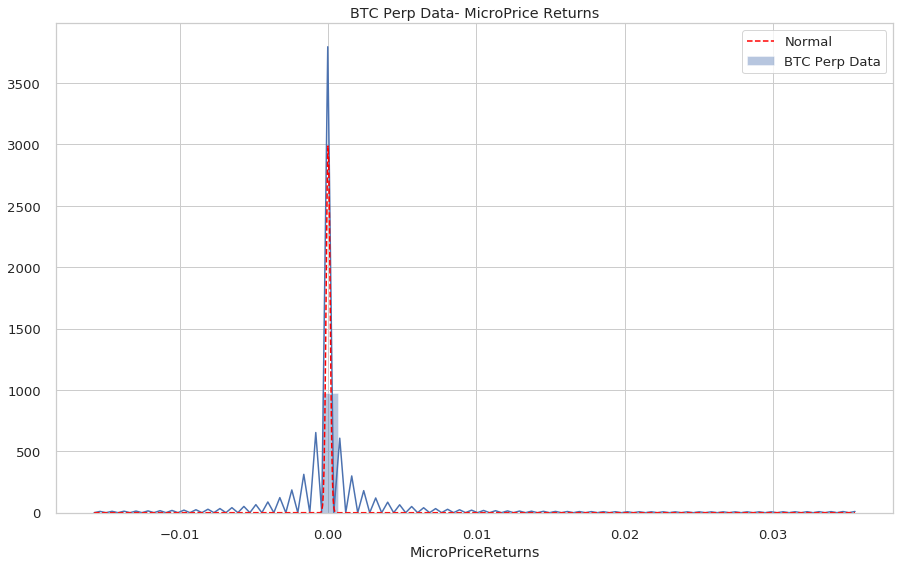

In [21]:
from scipy.stats import norm
x = np.linspace(np.min(df.MicroPriceReturns),np.max(df.MicroPriceReturns),1000)
y = norm.pdf(x, loc=np.mean(df.MicroPriceReturns), scale=np.std(df.MicroPriceReturns))    # for example

plt.figure(figsize=(15,9))
sns.light_palette("navy", reverse=True)
#sns.set_palette("husl")
sns.color_palette("PuBuGn_d")
sns.set_context("talk")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
ax=sns.distplot(df.MicroPriceReturns, label='BTC Perp Data')
plt.plot(x,y, color='red',linestyle='--',label='Normal')
ax.legend()
plt.title('BTC Perp Data- MicroPrice Returns')
ax.tick_params(right=False, top=False)

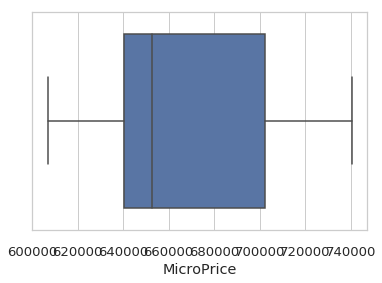

In [22]:
mad = mad_outlier(df.MicroPrice.values.reshape(-1,1))
_=sns.boxplot(df.loc[~mad].MicroPrice*100)

In [24]:

s1=df.bestAskSize
s2=df.bestBidSize
df['v']=pd.concat([s1, s2], axis=1).min(axis=1)
# np.min(df.bestAskSize, df.bestBidPrice)
df['dv']= df.v*df.MicroPrice

/home/ak/Envs/research/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ak/Envs/research/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
n_ticks = df.shape[0]
volume_ratio = (df.v.sum()/n_ticks).round()
dollar_ratio = (df.dv.sum()/n_ticks).round()
print('num ticks:', n_ticks)
print('volume ratio:', volume_ratio)
print('dollar ratio:', dollar_ratio)

('num ticks:', 27684849)
('volume ratio:', 444902.0)
('dollar ratio:', 2977671812.0)


In [26]:
tick_M = 100 # arbitrary
print('tick threshold:', tick_M)
tidx = tick_bars(df, 'MicroPrice', tick_M)
tidx[:10]



  2%|▏         | 446555/27684849 [00:00<00:06, 4465543.61it/s]

('tick threshold:', 100)


100%|██████████| 27684849/27684849 [00:04<00:00, 6185720.49it/s]


[99, 199, 299, 399, 499, 599, 699, 799, 899, 999]

In [27]:


tick_df = tick_bar_df(df, 'MicroPrice', tick_M)
tick_df.shape



100%|██████████| 27684849/27684849 [00:04<00:00, 6178189.32it/s]


(276848, 14)

In [28]:
def select_sample_data(ref, sub, price_col, idx_1,idx_2):
    '''
    select a sample of data based on date, assumes datetimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price column
        date: str(), date to select
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    '''
    xdf = df[price_col].iloc[idx_1:idx_2]
    xtdf = sub[price_col].iloc[idx_1:idx_2]
    return xdf, xtdf

## try different dates to see how the quantity of tick bars changes
idx_1=0
idx_2=10000
xdf, xtdf = select_sample_data(df, tick_df, 'MicroPrice', idx_1,idx_2)

xdf.shape, xtdf.shape

((10000,), (10000,))

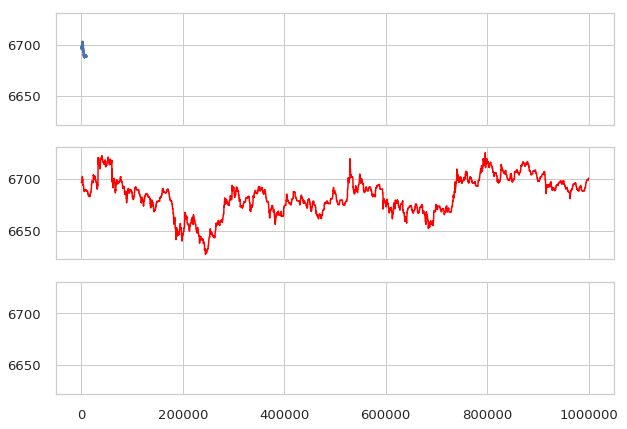

In [30]:
ref = xdf
sub =xtdf
f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
sns.lineplot(data=xdf,ax=axes[0], palette="tab10", linewidth=2.5)
sns.lineplot(data=xtdf,ax=axes[1],palette="tab25",color='red',linestyle='-' ,linewidth=1.5)

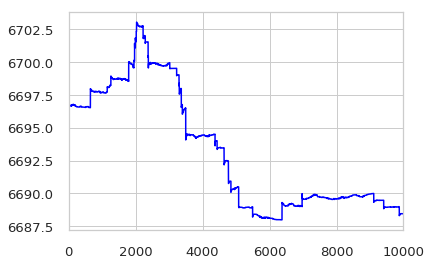

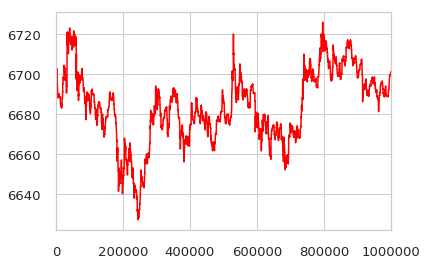

In [31]:
bar_type='tick bar'
# fig,axes=plt.subplots(3, figsize=(10,7))
ref=xdf
sub=xtdf
ref.plot(color='blue',label='price')
plt.show()
sub.plot(color='red',label=bar_type)
plt.show()


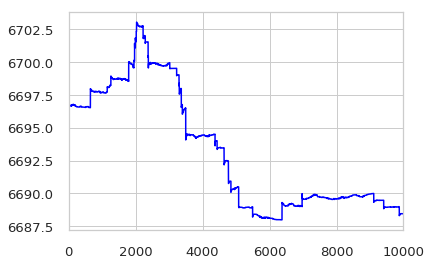

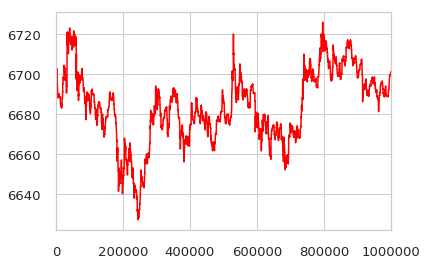

In [32]:
ax = ref.plot(color='blue',label='price')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.00f}'))
plt.show()
ax2 = sub.plot(color='red',label=bar_type)
num_ticks = 10

plt.show()

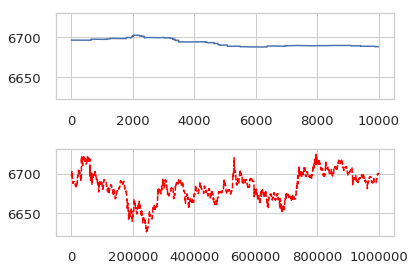

In [33]:

fig, axs = plt.subplots(2, 1,sharey=True)
axs[0].plot(ref)
axs[1].plot(sub, color= 'red',linestyle='--')
# axs[0].set_xlim(0, 2)

axs[0].grid(True)

for axs in axes:
    axs.set_xlabel('Common x-label')
    axs.set_ylabel('Common y-label')

fig.tight_layout()
plt.show()

/home/ak/Envs/research/local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


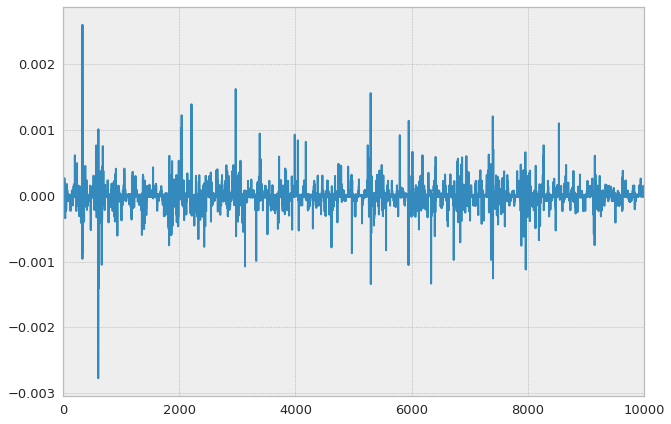

/home/ak/Envs/research/local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


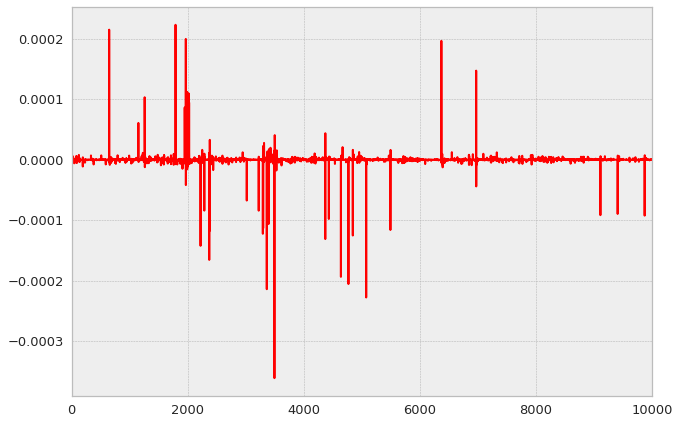

In [118]:

sub_returns =sub.pct_change().dropna()
ref_returns = ref.pct_change().dropna()

sns.tsplot(sub_returns)
plt.show()
sns.tsplot(ref_returns, color='red')
plt.show()

In [ ]:
# def autocorr(x):
#     n = x.size
#     norm = (x - np.mean(x))
#     result = np.correlate(norm, norm, mode='same')
#     acorr = result[n//2 + 1:] / (x.var() * np.arange(n-1, n//2, -1))
#     lag = np.abs(acorr).argmax() + 1
#     r = acorr[lag-1]        
#     if np.abs(r) > 0.5:
#         print('Appears to be autocorrelated with r = {}, lag = {}'. format(r, lag))
#     else: 
#         print('Appears to be not autocorrelated')
#     return r, lag


In [35]:
df['SqrdReturns']=(df.MicroPriceReturns**2)*100

/home/ak/Envs/research/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


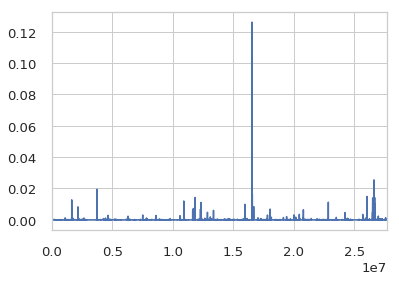

In [36]:
df.SqrdReturns.plot()

In [31]:
import statsmodels as sts
# Importing lag_plot
# from pandas import lag_plot
# from pandas import autocorrelation_plot


In [38]:
series = df.MicroPrice

# import pandas as pd
import datetools

In [ ]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# # plot_acf(series)
# # plt.show()
# # # plot_pacf(series)
# # # plt.show()

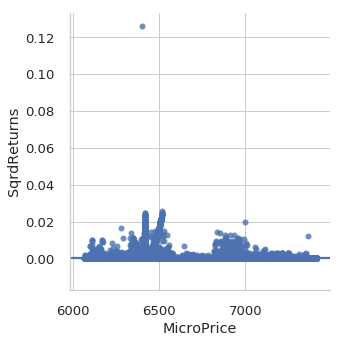

In [39]:
sns.lmplot(x='MicroPrice', y='SqrdReturns', data=df)
#do calculation using high and low

In [90]:
sample=df[:20000]

In [91]:
len(sample)

20000

In [93]:
fit_returns_discrete = powerlaw.Fit(sample.MicroPriceReturns, discrete=False) 
fitwolf = powerlaw.Fit(sample.MicroPriceReturns, discrete=True)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [94]:
df.shape

(27684849, 15)

In [95]:
data= sample.MicroPriceReturns
####
import powerlaw
fit = powerlaw.Fit(data)
fit.power_law.alpha
fit.power_law.sigma
fit.distribution_compare('power_law', 'exponential')

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


(958.9591031602828, 3.716010049035742e-17)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


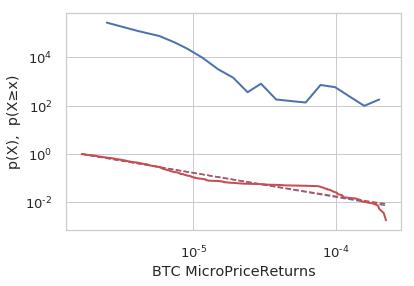

In [96]:
fit = powerlaw.Fit(data, discrete=True)
####
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)
fit.plot_ccdf(color='r', linewidth=2, ax=figCCDF)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)
####
figCCDF.set_ylabel(u"p(X),  p(X≥x)")
figCCDF.set_xlabel(r"BTC MicroPriceReturns")

figname = 'FigCCDF'

In [97]:
fit = powerlaw.Fit(data)
###
x, y = fit.cdf()
bin_edges, probability = fit.pdf()
y = fit.lognormal.cdf(data=[300,350])
y = fit.lognormal.pdf()

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


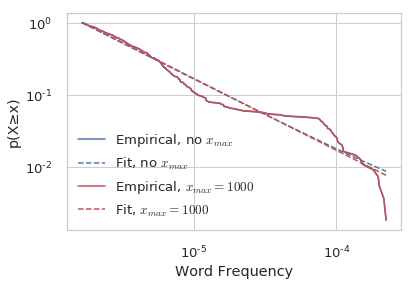

In [98]:
fit = powerlaw.Fit(data, discrete=True, xmax=None)
FigCCDFmax = fit.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
fit.power_law.plot_ccdf(color='b', linestyle='--', ax=FigCCDFmax, label=r"Fit, no $x_{max}$")
fit = powerlaw.Fit(data, discrete=True, xmax=1000)
fit.plot_ccdf(color='r', label=r"Empirical, $x_{max}=1000$")
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=FigCCDFmax, label=r"Fit, $x_{max}=1000$")
#x, y = powerlaw.ccdf(data, xmax=max(data))
#fig1.plot(x,y)
####
#FigCCDFmax.set_ylabel(r"$p(X\geq x)$")
FigCCDFmax.set_ylabel(u"p(X≥x)")
FigCCDFmax.set_xlabel(r"Word Frequency")
handles, labels = FigCCDFmax.get_legend_handles_labels()
leg = FigCCDFmax.legend(handles, labels, loc=3)
leg.draw_frame(False)

figname = 'FigCCDFmax'
# savefig(figname+'.eps', bbox_inches='tight')
#savefig(figname+'.tiff', bbox_inches='tight', dpi=300)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


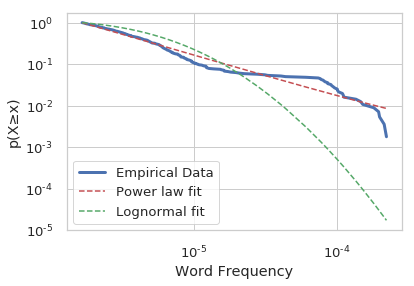

In [99]:
fit = powerlaw.Fit(data, discrete=True)
####
fit.distribution_compare('power_law', 'lognormal')
fig = fit.plot_ccdf(linewidth=3, label='Empirical Data')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
####
fig.set_ylabel(u"p(X≥x)")
fig.set_xlabel("Word Frequency")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3)

In [100]:
df_crypto.columns.values

array(['Unnamed: 0', 'bestBidPrice', 'bestBidSize', 'bestAskPrice',
       'bestAskSize', 'timestamp', 'time', 'date', 'milliSeconds',
       'duration', 'MicroPrice', 'MicroPriceReturns'], dtype=object)

In [101]:
tick_M = 20 # arbitrary
print('tick threshold:', tick_M)
tidx = tick_bars(df_crypto, 'MicroPrice', tick_M)
tidx[:10]


  2%|▏         | 434068/27684850 [00:00<00:06, 4340673.79it/s]

('tick threshold:', 20)


100%|██████████| 27684850/27684850 [00:04<00:00, 6111708.76it/s]


[19, 39, 59, 79, 99, 119, 139, 159, 179, 199]

In [102]:
crypto_tick_df = tick_bar_df(df_crypto, 'MicroPrice', tick_M)
crypto_tick_df.shape

100%|██████████| 27684850/27684850 [00:04<00:00, 6035402.26it/s]


(1384242, 12)

In [103]:
## try different dates to see how the quantity of tick bars changes
idx_1=0
idx_2=1000000
# perp_xdf, perp_xtdf = select_sample_data(df_crypto, crypto_tick_df, 'MicroPrice', idx_1,idx_2)

# perp_xdf.shape, perp_xtdf.shape
crypto_tick_df.head(4)

,Unnamed: 0,bestBidPrice,bestBidSize,bestAskPrice,bestAskSize,timestamp,time,date,milliSeconds,duration,MicroPrice,MicroPriceReturns
19,20,6696.5,1148160.0,6697.0,367214.0,2018-08-26 13:21:40.332000+00:00,13:21:40.332000,2018-08-26,48100000.0,0.0,6696.621163,0.000000e+00
39,40,6696.5,1048660.0,6697.0,676364.0,2018-08-26 13:21:41.609000+00:00,13:21:41.609000,2018-08-26,48101000.0,0.0,6696.696045,0.000000e+00
59,60,6696.5,1223292.0,6697.0,472620.0,2018-08-26 13:21:42.555000+00:00,13:21:42.555000,2018-08-26,48102000.0,0.0,6696.639341,-1.226930e-11
79,80,6696.5,1217966.0,6697.0,695804.0,2018-08-26 13:21:43.964000+00:00,13:21:43.964000,2018-08-26,48103000.0,0.0,6696.681789,-6.827579e-08


In [83]:
dta_plain = sample.MicroPriceReturns

In [88]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

In [82]:
# data = perp_xdf

# sns.lineplot(data=perp_xdf, palette="tab10", linewidth=2.5)
# plt.show()
# sns.lineplot(data=perp_xtdf,palette="tab25",color='red',linestyle='-' ,linewidth=1.5)

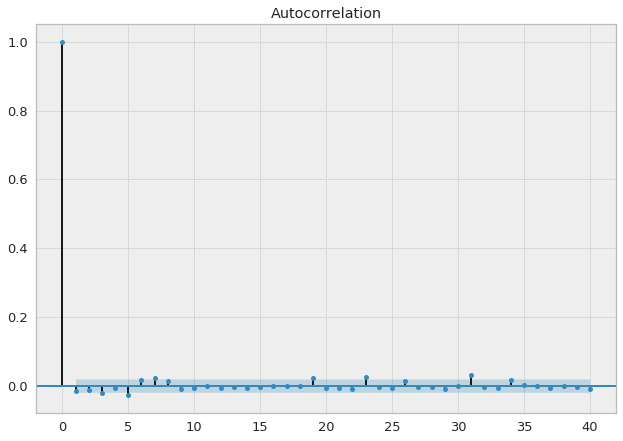

In [125]:
sm.graphics.tsa.plot_acf(ref_returns.values.squeeze(), lags=40)
plt.show()

In [143]:
def pacf_graph(df,title):
    sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=40)
    plt.title(title)
    plt.show()

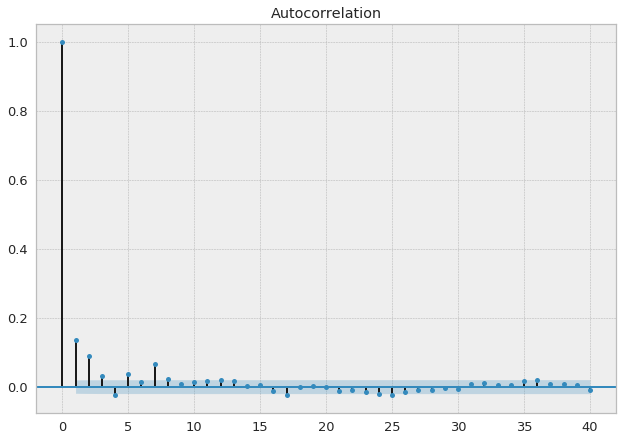

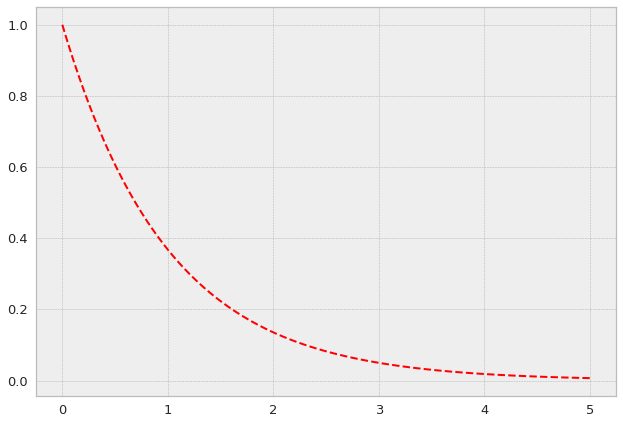

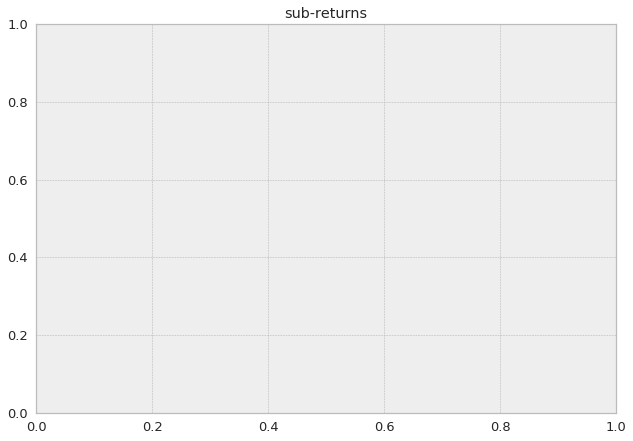

In [144]:
pacf_graph(sub_returns,'sub-returns')

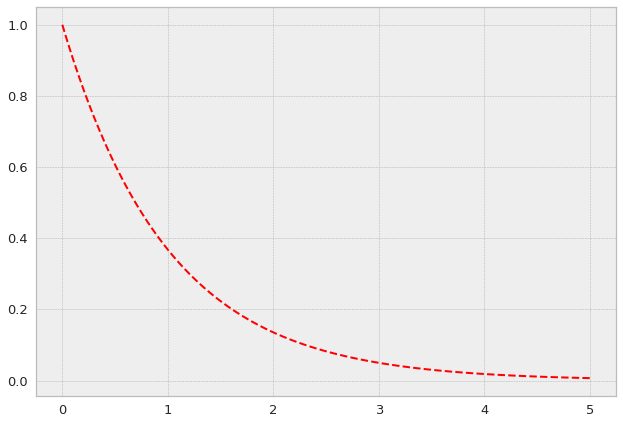

In [142]:
def expo_decay():
    x = np.linspace(0, 5, 100)
    y = np.exp(x)
    plt.figure()
    plt.plot(x, np.exp(-x), color='red',linestyle='--')
#     plt.xlabel('$x$')
#     plt.ylabel('$-\exp(-x)$')

    plt.show()
expo_decay()

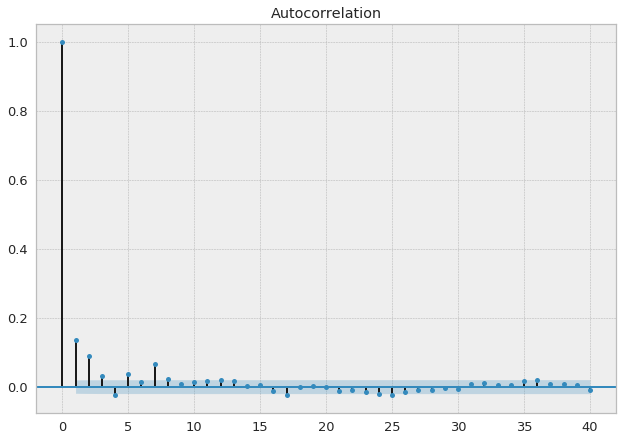

In [128]:
fig = tsaplots.plot_acf(sub_returns.values, lags=40)